# Aequitas Exercise: Car Evaluation Dataset

The data from this exercise comes from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation For more details on the data set see the included documentation.

In [1]:
import sys
#!{sys.executable} -m pip install aequitas==0.42 pandas==1.2.3
!{sys.executable} -m pip install aequitas==0.42

In [35]:
# Imports
from aequitas.plotting import Plot
ap = Plot()
import pandas as pd

from aequitas.group import Group
from aequitas.bias import Bias 
from aequitas.fairness import Fairness

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [36]:
# I manually added the headers to the data set.
df = pd.read_csv("car.csv")

In [37]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,car
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [38]:
df.car.value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: car, dtype: int64

We need to collapse this to a binary prediction problem. 

In [39]:
# Modify the data to make it a binary problem of acceptable or unacceptable car.
df.car.replace(["good", "vgood"], "acc", inplace=True)

In [40]:
df.car.value_counts()

unacc    1210
acc       518
Name: car, dtype: int64

In [41]:
y = df.pop('car')
X = df

df.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# Use this later to construct the DataFrame Aequitas requires.
df_aq = X_test.reset_index(drop=True).copy()

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_train = ohe.fit_transform(X_train.values)
X_test = ohe.transform(X_test.values)

lb = LabelBinarizer()
y_train = label_binarize(y_train.values, classes=['unacc', 'acc']).ravel()
y_test = label_binarize(y_test.values, classes=['unacc', 'acc']).ravel()

X_train shape:  (1296, 6)
X_test shape:  (432, 6)


In [43]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

scores = lr.predict_proba(X_test)
pred = lr.predict(X_test)

f1 = f1_score(y_test, pred)
print(f"F1 score: {f1:.4f}")

F1 score: 0.8960


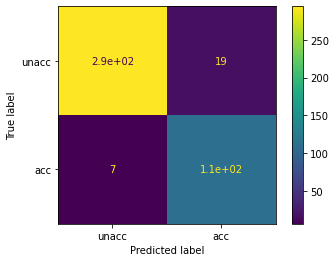

In [44]:
cm = confusion_matrix(y_test, pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["unacc", "acc"]).plot()

In [45]:
# Construct the dataframe that Aequitas will use.
df_aq['label_value'] = y_test
df_aq['score'] = pred
df_aq.head()

,buying,maint,doors,persons,lug_boot,safety,label_value,score
0,med,low,5more,4,small,low,0,0
1,high,vhigh,3,more,small,low,0,0
2,low,low,4,4,med,high,1,1
3,low,high,3,4,med,med,1,1
4,vhigh,high,5more,4,big,high,0,1


It is always a good idea to see how predictions are distributed across the categories of features. For example, for cars that can seat only 2 persons are always correctly classified as unacceptable. Cars that have low safety are also always classified as unacceptable. 

This can cause some statistics (`False Positive Rate`, `False Negative Rate`) to be zero or NAN because there are no false positives or false negatives. 

For the `persons` column, we can show this behavior below.

In [46]:
pd.crosstab(df_aq.score, df_aq.persons)

persons,2,4,more
score,,,
0,143,79,79
1,0,70,61


In [47]:
pd.crosstab(df_aq.label_value, df_aq.persons)

persons,2,4,more
label_value,,,
0,143,87,83
1,0,62,57


In [48]:
# select predictions where 
y_test_person_eq_2 = y_test[df_aq.loc[df_aq.persons == "2"].index]
y_pred_person_eq_2 = pred[df_aq.loc[df_aq.persons == "2"].index]

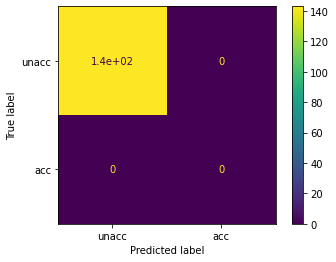

In [49]:
cm_person_eq_2 = confusion_matrix(y_test_person_eq_2, y_pred_person_eq_2, labels=[0, 1])
ConfusionMatrixDisplay(cm_person_eq_2, display_labels=["unacc", "acc"]).plot()

In [51]:
# Run Aequitas.
group = Group()
xtab, idxs = group.get_crosstabs(df_aq)
xtab.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
model_id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
score_threshold,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1
k,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131
attribute_name,buying,buying,buying,buying,maint,maint,maint,maint,doors,doors,doors,doors,persons,persons,persons,lug_boot,lug_boot,lug_boot,safety,safety,safety
attribute_value,high,low,med,vhigh,high,low,med,vhigh,2,3,4,5more,2,4,more,big,med,small,high,low,med
tpr,0.913043,0.972973,1,0.777778,0.896552,0.948718,0.947368,1,0.85,0.921053,1,0.96875,NaN,0.951613,0.929825,0.954545,0.959184,0.884615,0.971014,NaN,0.9
tnr,0.9,0.963636,0.946667,0.956989,0.929412,0.916667,0.923077,0.978022,0.938272,0.9375,0.938272,0.943662,1,0.873563,0.903614,0.977273,0.932692,0.917355,0.911765,1,0.867347
for,0.0240964,0.0185185,0,0.0430108,0.0365854,0.0294118,0.0322581,0,0.0379747,0.0384615,0,0.0147059,0,0.0379747,0.0506329,0.0227273,0.020202,0.0263158,0.03125,0,0.0555556
fdr,0.3,0.0526316,0.0888889,0.222222,0.1875,0.139535,0.121951,0.133333,0.227273,0.125,0.147059,0.114286,NaN,0.157143,0.131148,0.0454545,0.12963,0.30303,0.0821918,NaN,0.224138
fpr,0.1,0.0363636,0.0533333,0.0430108,0.0705882,0.0833333,0.0769231,0.021978,0.0617284,0.0625,0.0617284,0.056338,0,0.126437,0.0963855,0.0227273,0.0673077,0.0826446,0.0882353,0,0.132653


In [52]:
bias = Bias()
bias_df = bias.get_disparity_major_group(xtab, original_df=df_aq, alpha=0.05, mask_significance=True)
bias_df.T

get_disparity_major_group()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
model_id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
score_threshold,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1
k,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131
attribute_name,buying,buying,buying,buying,maint,maint,maint,maint,doors,doors,doors,doors,persons,persons,persons,lug_boot,lug_boot,lug_boot,safety,safety,safety
attribute_value,high,low,med,vhigh,high,low,med,vhigh,2,3,4,5more,2,4,more,big,med,small,high,low,med
tpr,0.913043,0.972973,1,0.777778,0.896552,0.948718,0.947368,1,0.85,0.921053,1,0.96875,NaN,0.951613,0.929825,0.954545,0.959184,0.884615,0.971014,NaN,0.9
tnr,0.9,0.963636,0.946667,0.956989,0.929412,0.916667,0.923077,0.978022,0.938272,0.9375,0.938272,0.943662,1,0.873563,0.903614,0.977273,0.932692,0.917355,0.911765,1,0.867347
for,0.0240964,0.0185185,0,0.0430108,0.0365854,0.0294118,0.0322581,0,0.0379747,0.0384615,0,0.0147059,0,0.0379747,0.0506329,0.0227273,0.020202,0.0263158,0.03125,0,0.0555556
fdr,0.3,0.0526316,0.0888889,0.222222,0.1875,0.139535,0.121951,0.133333,0.227273,0.125,0.147059,0.114286,NaN,0.157143,0.131148,0.0454545,0.12963,0.30303,0.0821918,NaN,0.224138
fpr,0.1,0.0363636,0.0533333,0.0430108,0.0705882,0.0833333,0.0769231,0.021978,0.0617284,0.0625,0.0617284,0.056338,0,0.126437,0.0963855,0.0227273,0.0673077,0.0826446,0.0882353,0,0.132653


In [53]:
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)
fairness_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
model_id,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
score_threshold,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1,binary 0/1
k,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131
attribute_name,buying,buying,buying,buying,maint,maint,maint,maint,doors,doors,doors,doors,persons,persons,persons,lug_boot,lug_boot,lug_boot,safety,safety,safety
attribute_value,high,low,med,vhigh,high,low,med,vhigh,2,3,4,5more,2,4,more,big,med,small,high,low,med
tpr,0.913043,0.972973,1,0.777778,0.896552,0.948718,0.947368,1,0.85,0.921053,1,0.96875,NaN,0.951613,0.929825,0.954545,0.959184,0.884615,0.971014,NaN,0.9
tnr,0.9,0.963636,0.946667,0.956989,0.929412,0.916667,0.923077,0.978022,0.938272,0.9375,0.938272,0.943662,1,0.873563,0.903614,0.977273,0.932692,0.917355,0.911765,1,0.867347
for,0.0240964,0.0185185,0,0.0430108,0.0365854,0.0294118,0.0322581,0,0.0379747,0.0384615,0,0.0147059,0,0.0379747,0.0506329,0.0227273,0.020202,0.0263158,0.03125,0,0.0555556
fdr,0.3,0.0526316,0.0888889,0.222222,0.1875,0.139535,0.121951,0.133333,0.227273,0.125,0.147059,0.114286,NaN,0.157143,0.131148,0.0454545,0.12963,0.30303,0.0821918,NaN,0.224138
fpr,0.1,0.0363636,0.0533333,0.0430108,0.0705882,0.0833333,0.0769231,0.021978,0.0617284,0.0625,0.0617284,0.056338,0,0.126437,0.0963855,0.0227273,0.0673077,0.0826446,0.0882353,0,0.132653


In [54]:
overall_fairness = fairness.get_overall_fairness(fairness_df)
print(overall_fairness)

{'Unsupervised Fairness': False, 'Supervised Fairness': False, 'Overall Fairness': False}


In [55]:
metrics = ['fpr', "for", "fnr"]
disparity_metrics = [f"{metric}_disparity" for metric in metrics]

In [56]:
# Just as we discussed above, some statistics are zero or NAN
bias_df[["attribute_name", "attribute_value"] + metrics + disparity_metrics]

,attribute_name,attribute_value,fpr,for,fnr,fpr_disparity,for_disparity,fnr_disparity
0,buying,high,0.100000,0.024096,0.086957,1.875000,10.000000,10.000000
1,buying,low,0.036364,0.018519,0.027027,0.681818,10.000000,10.000000
2,buying,med,0.053333,0.000000,0.000000,1.000000,NaN,NaN
3,buying,vhigh,0.043011,0.043011,0.222222,0.806452,10.000000,10.000000
4,maint,high,0.070588,0.036585,0.103448,1.000000,1.000000,1.000000
5,maint,low,0.083333,0.029412,0.051282,1.180556,0.803922,0.495726
6,maint,med,0.076923,0.032258,0.052632,1.089744,0.881720,0.508772
7,maint,vhigh,0.021978,0.000000,0.000000,0.311355,0.000000,0.000000
8,doors,2,0.061728,0.037975,0.150000,0.987654,0.987342,1.900000
9,doors,3,0.062500,0.038462,0.078947,1.000000,1.000000,1.000000


In [57]:
# To avoid issues when plotting, add an epilon (0.000001) to cases where statistics are zero or NAN
eps = 0.000001
bias_df[disparity_metrics] = bias_df[disparity_metrics].fillna(0.0) + eps

In [58]:
bias_df[["attribute_name", "attribute_value"] + metrics + disparity_metrics]

,attribute_name,attribute_value,fpr,for,fnr,fpr_disparity,for_disparity,fnr_disparity
0,buying,high,0.100000,0.024096,0.086957,1.875001,10.000001,10.000001
1,buying,low,0.036364,0.018519,0.027027,0.681819,10.000001,10.000001
2,buying,med,0.053333,0.000000,0.000000,1.000001,0.000001,0.000001
3,buying,vhigh,0.043011,0.043011,0.222222,0.806453,10.000001,10.000001
4,maint,high,0.070588,0.036585,0.103448,1.000001,1.000001,1.000001
5,maint,low,0.083333,0.029412,0.051282,1.180557,0.803923,0.495727
6,maint,med,0.076923,0.032258,0.052632,1.089745,0.881721,0.508773
7,maint,vhigh,0.021978,0.000000,0.000000,0.311356,0.000001,0.000001
8,doors,2,0.061728,0.037975,0.150000,0.987655,0.987343,1.900001
9,doors,3,0.062500,0.038462,0.078947,1.000001,1.000001,1.000001


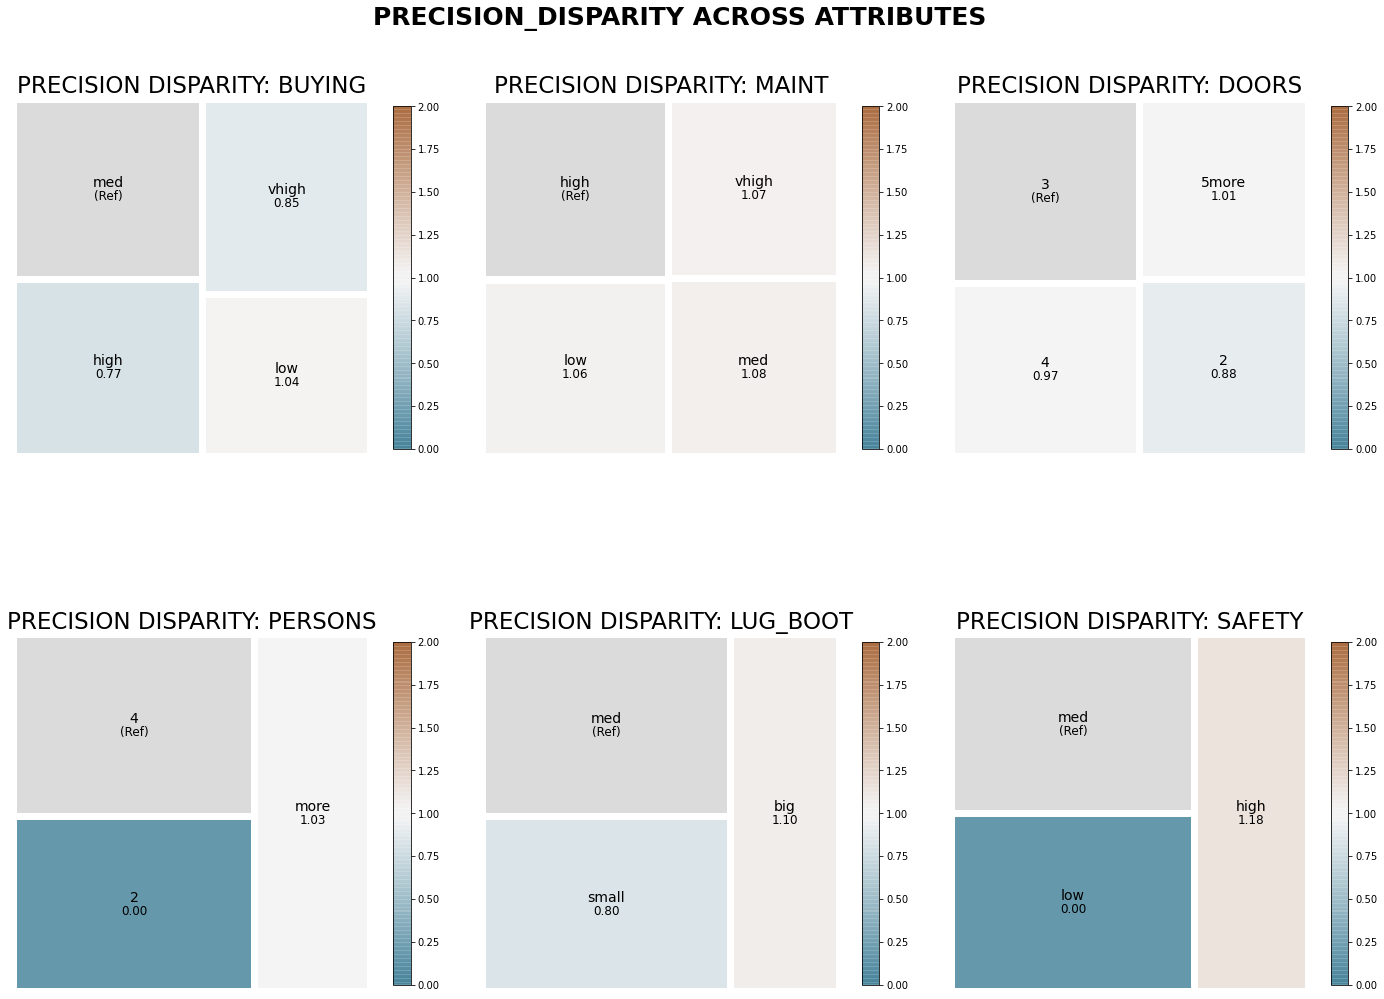

In [59]:
disparity_tolerance = 1.25

# Deprecated function summary()
# ap.summary(bias_df, metrics, fairness_threshold=disparity_tolerance)

# Aequitas Fairness() class provides a few functions that provide a high level summary of fairness and disparity, such as 
# plot_fairness_group()
# plot_fairness_group_all()
# plot_fairness_disparity()
# plot_fairness_disparity_all()
# plot_disparity()
# See some example here: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb 
p = ap.plot_disparity_all(bias_df, metrics=['precision_disparity'], significance_alpha=0.05)
